# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

1. [Test Images](#testimages)
* [Build the Color Pipeline](#buildcolorpipe)

    1. [Color Selection](#colorselection)  
    * [Region of interest](#roi)
    * [Fitting Line](#fittingline1)
    * [Pipeline](#pipelinetest1)
    * [VIDEO](#video1)
* [Build the Hough Lines Pipeline](#buildhoughpipe)

    1. [Canny Edge Detection](#canny)
    * [Hough Lines](#hough)
    * [Class Lines and Fitting](#line)
    * [Pipeline And Test](#pipe2)
    * [VIDEO](#video2)
    


In [1]:
#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from pathlib import Path

# All function in this files are explained here.
from helper_function import *
from line_class import Line

# Import everything needed to edit/save video clips
from moviepy.editor import VideoFileClip

%matplotlib inline

<a id="testimages"/>

## Test Images

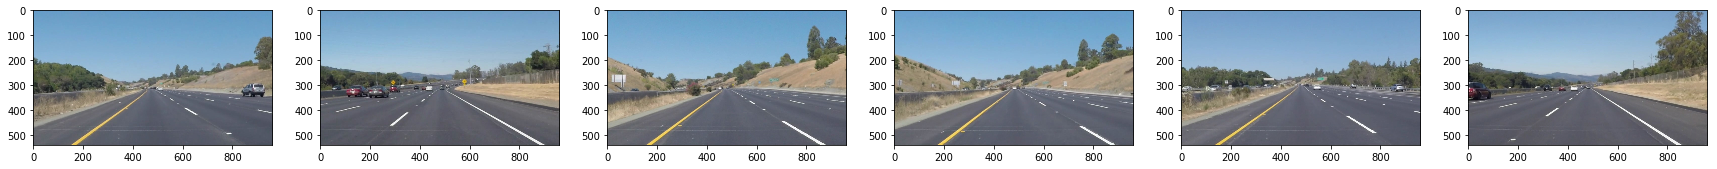

In [2]:
p = Path("test_images/")
imgs = p.glob("*.jpg")
fig, axs = plt.subplots(1,6,figsize=(30,20))
for i,img in enumerate(imgs):
    axs[i].imshow(mpimg.imread(img))

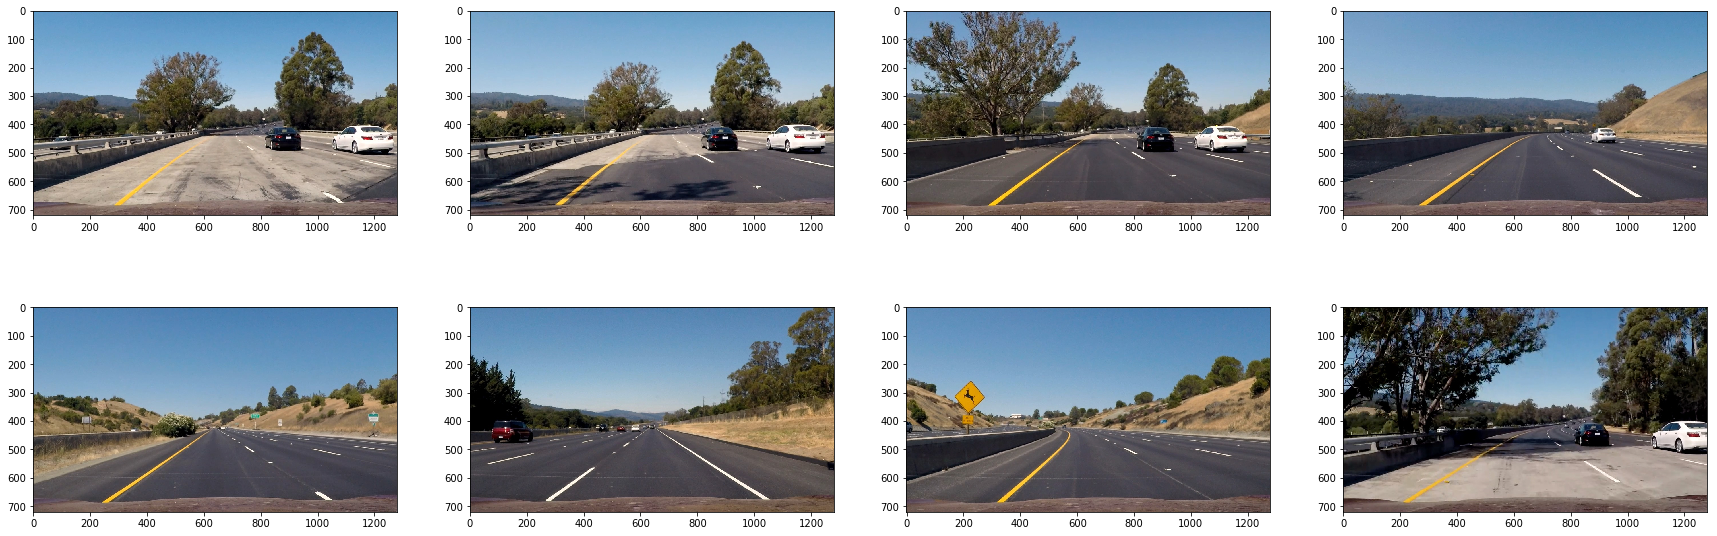

In [3]:
p2 = p / "Advanced_images/"
imgs = p2.glob("*.jpg")
fig, axs = plt.subplots(2,4,figsize=(30,10))
axs = axs.flatten()
for i,img in enumerate(imgs):
    axs[i].imshow(mpimg.imread(img))

In [4]:
image = mpimg.imread(p / "solidWhiteRight.jpg")

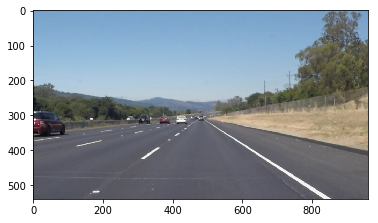

In [5]:
plt.imshow(image);

In [6]:
test_functions?

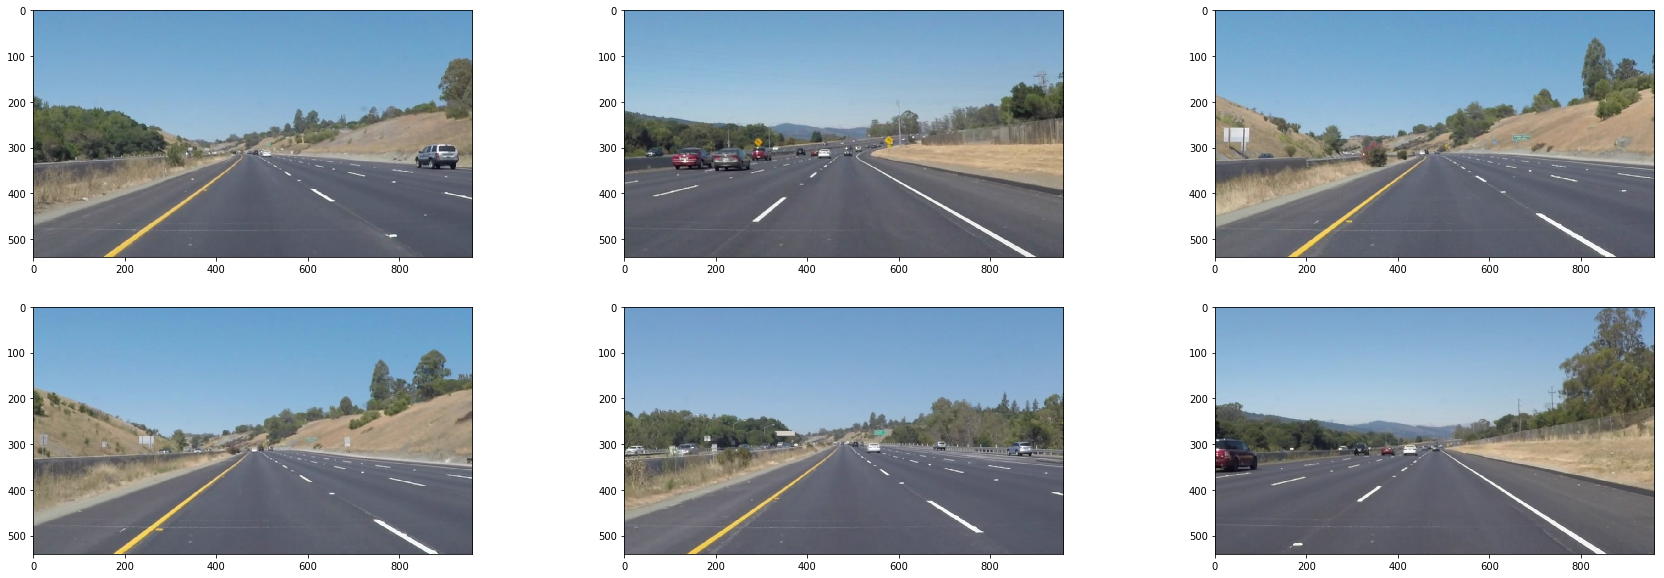

In [7]:
test_functions(p)

<a id="buildcolorpipe"/>

## Build a Lane Finding Pipeline

<a id="colorselection"/>

#### Color Selection

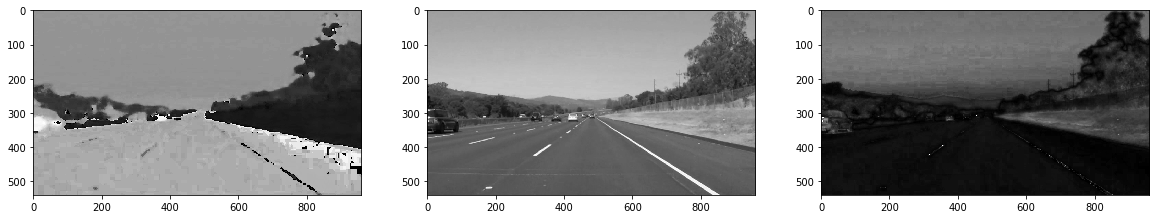

In [8]:
img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

fig, axs = plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    axs[i].imshow(img_hls[:,:,i],cmap="gray")

BLACK pixel close to the 0

WHITE pixel close to 255

[[[  0 255   0]]]


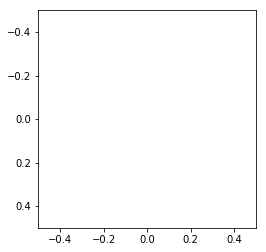

In [9]:
i  = np.ones((1,1,3),dtype="uint8") * 255
print(cv2.cvtColor(i, cv2.COLOR_RGB2HLS))
plt.imshow(i);

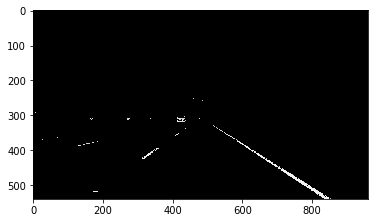

In [10]:
white_threshold =  (np.array([0, 200, 0]), np.array([255, 255, 50]))


white_mask = cv2.inRange(img_hls, *white_threshold)
white_img = cv2.bitwise_or(image, image, mask=white_mask)
plt.imshow(white_img)

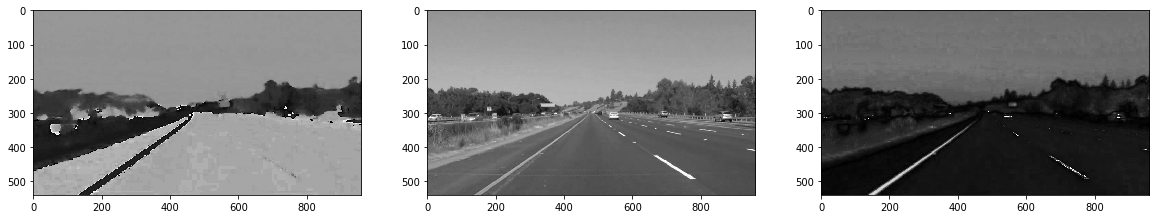

In [11]:
yellow_lines = mpimg.imread(p / "solidYellowLeft.jpg")
yellow_hls = cv2.cvtColor(yellow_lines, cv2.COLOR_RGB2HLS)

fig, axs = plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    axs[i].imshow(yellow_hls[:,:,i],cmap="gray")

In [12]:
y = np.zeros((1,1,3),dtype="uint8")
y[:,:,:2] = 255
cv2.cvtColor(y, cv2.COLOR_RGB2HLS)

array([[[ 30, 128, 255]]], dtype=uint8)

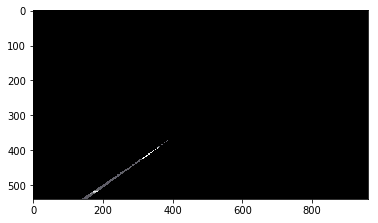

In [13]:
yellow_threshold =  (np.array([0, 80, 150]), np.array([80, 180, 255]))

yellow_mask = cv2.inRange(yellow_hls, *yellow_threshold)
yellow_img = cv2.bitwise_or(image, image, mask=yellow_mask)
plt.imshow(yellow_img)

In [14]:
color_selection?

In [15]:
yellow_white_selection?

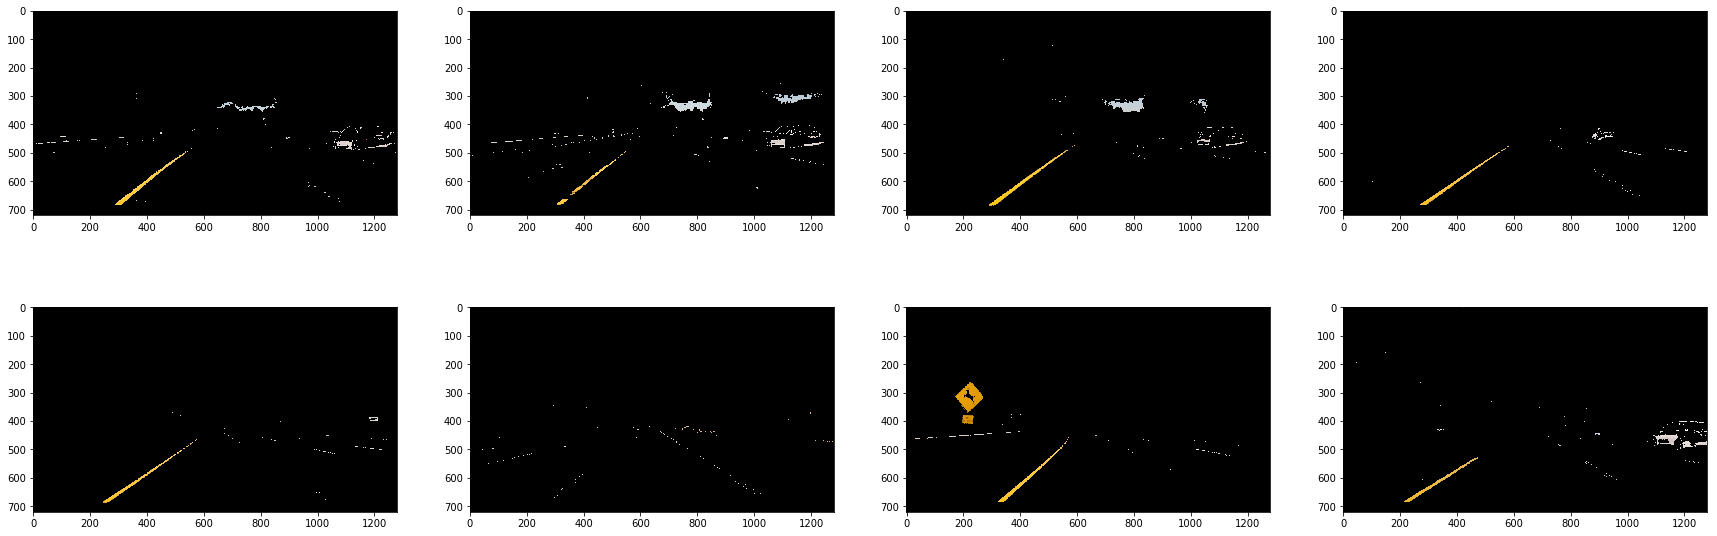

In [16]:
test_functions(p2, yellow_white_selection)

[Test image original](#testimages)

<a id="roi"/>

#### Region of interest

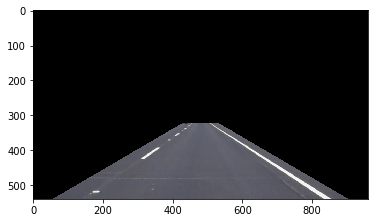

In [17]:
mask = np.zeros_like(image)
imshape = image.shape
vertices = np.array([[(imshape[1]/17,imshape[0]),
                      (4*imshape[1]/9, 9*imshape[0]/15), 
                      (5*imshape[1]/9, 9*imshape[0]/15), 
                
                      (16*imshape[1]/17,imshape[0])]], dtype=np.int32)
#defining a 3 channel or 1 channel color to fill the mask with depending on the input image
if len(image.shape) > 2:
    channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255

cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_image = cv2.bitwise_and(image, mask)
plt.imshow(masked_image);

In [18]:
vertices

array([[[ 56, 540],
        [426, 324],
        [533, 324],
        [903, 540]]], dtype=int32)

In [19]:
region_of_interest?

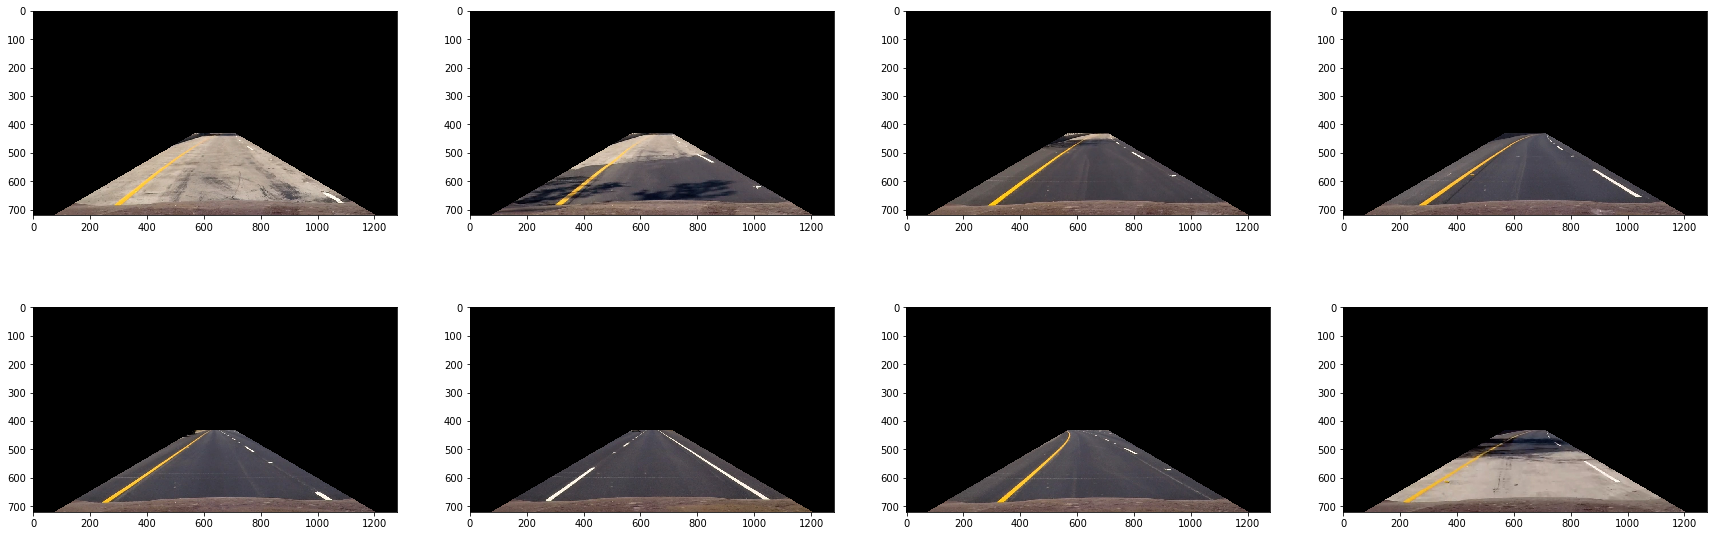

In [20]:
test_functions(p2, region_of_interest)

[Test image original](#testimages)

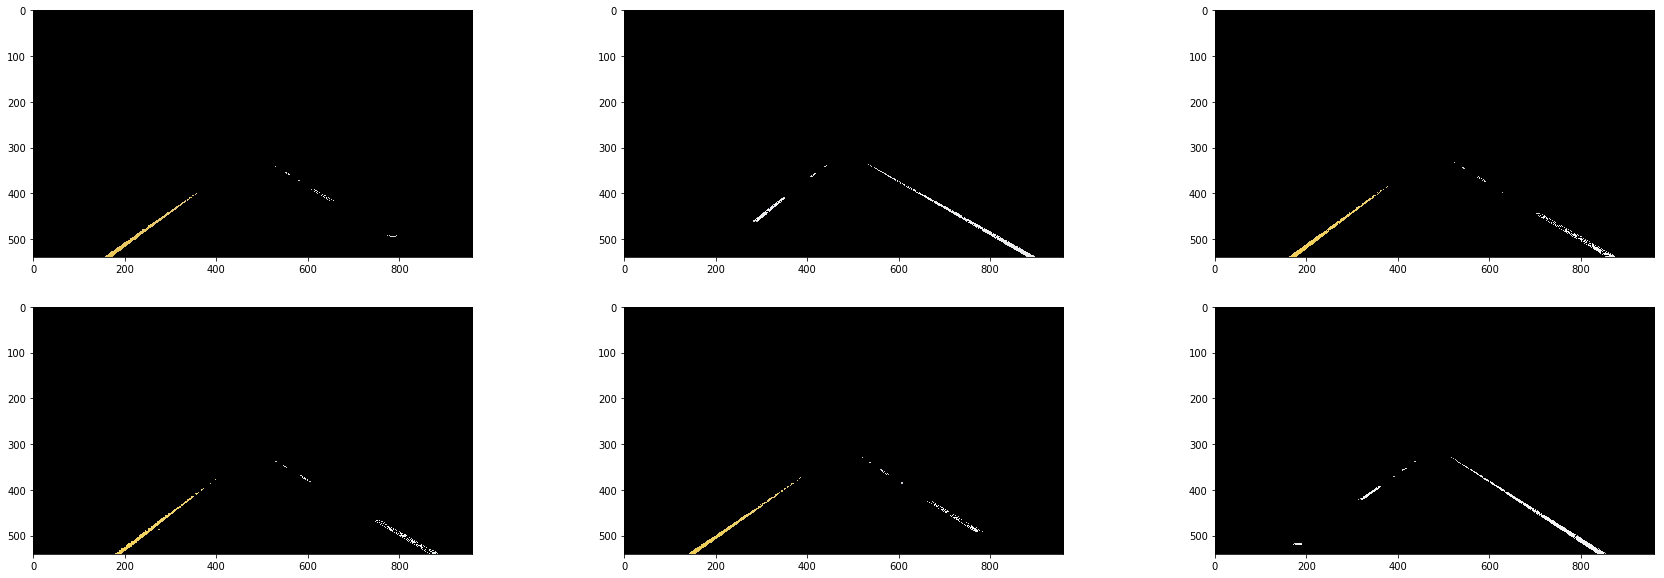

In [21]:
test_functions(p,lambda x: region_of_interest(yellow_white_selection(x)))

<a id="fittingline1"/>

### Fittting a line

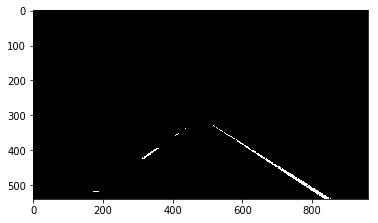

In [22]:
yellow_white_lanes = yellow_white_selection(masked_image)
bw_img = byte_image(yellow_white_lanes)
plt.imshow(bw_img, cmap="gray")

I will separte the two lines. This'll not working if the car is above the line.

In [23]:
left_img = bw_img[:,:bw_img.shape[1]//2]
right_img = bw_img[:,bw_img.shape[1]//2:]

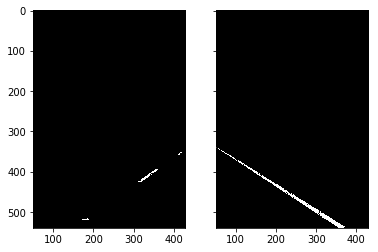

In [24]:
fig, axs = plt.subplots(1,2,sharey=True)
axs[0].imshow(left_img, cmap="gray")
axs[1].imshow(right_img,cmap='gray')

In [25]:
points_r = np.where(right_img > 0)
points_l = np.where(left_img > 0)

In [26]:
f_r = np.poly1d(np.polyfit(*points_r,1))
f_l = np.poly1d(np.polyfit(*points_l,1))

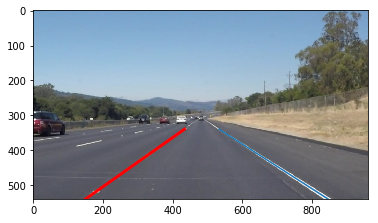

In [27]:
y = np.linspace(340,540)

plt.plot(f_l(y),y,"r",linewidth= 3)
plt.plot(f_r(y)+480,y)
plt.imshow(image, cmap="gray")

<a id="pipelinetest1"/>

In [28]:
def pipeline(img):
    
    roi_img = region_of_interest(img)
    yw_img = yellow_white_selection(roi_img)
    byte_img = byte_image(yw_img)
    
    left_img = byte_img[:,:byte_img.shape[1]//2]
    right_img = byte_img[:,byte_img.shape[1]//2:]
    
    left_line = points(left_img)
    right_line = points(right_img, x=left_img.shape[1])
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    draw_lines(line_img,[left_line,right_line])
    
    return weighted_img(line_img,img)

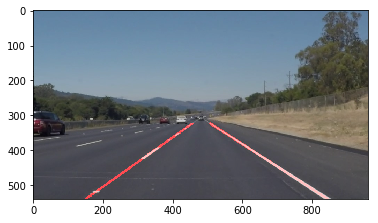

In [29]:
plt.imshow(pipeline(image));

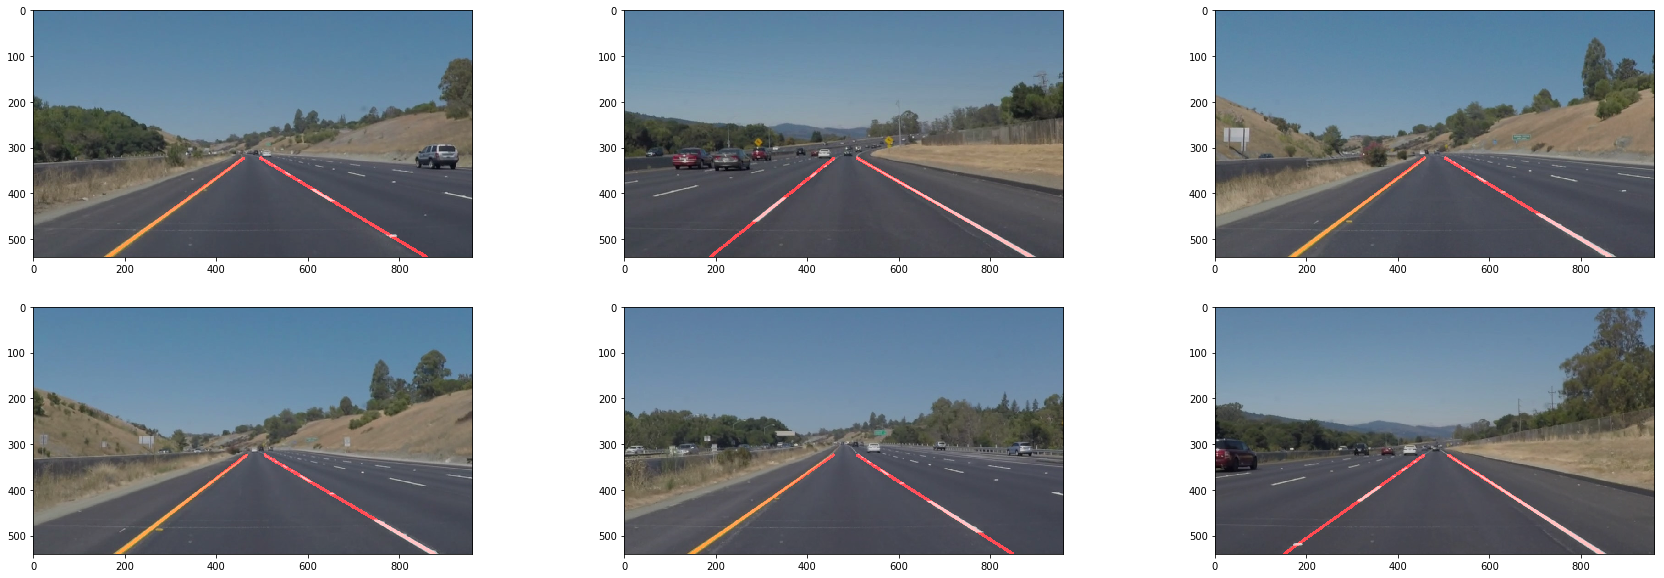

In [30]:
test_functions(p, pipeline)

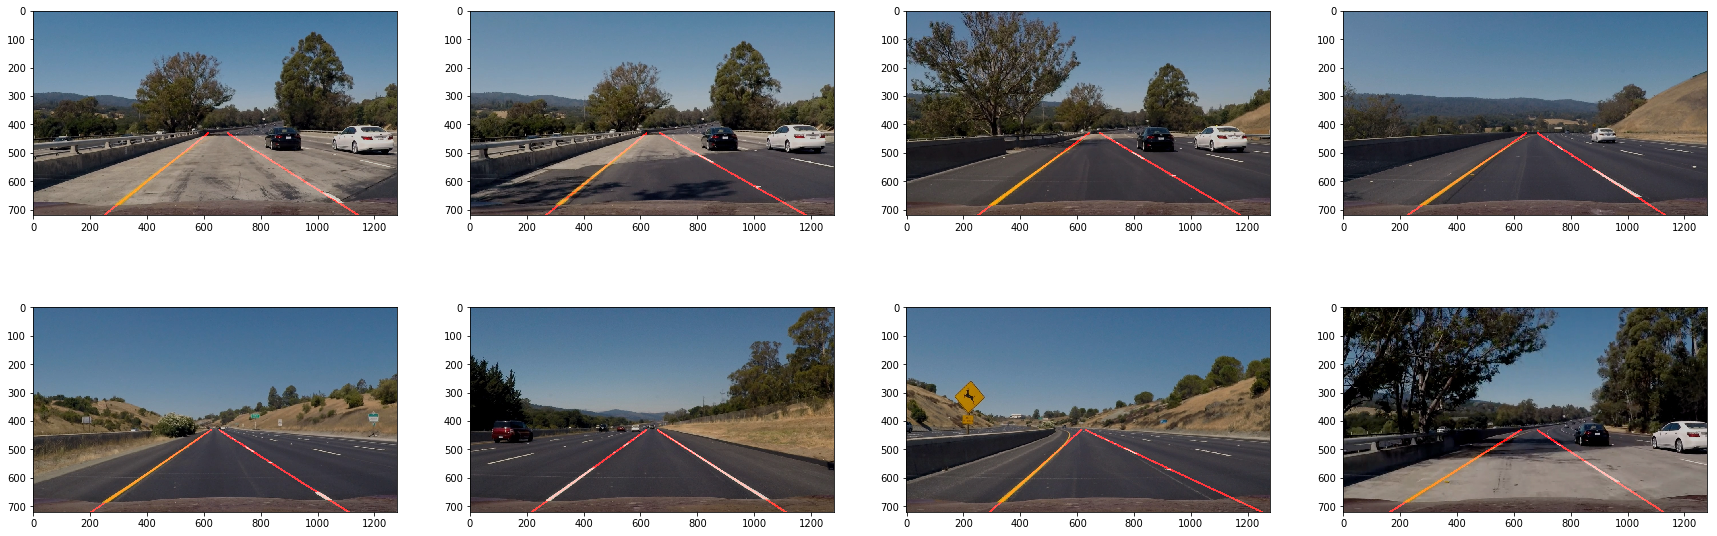

In [31]:
test_functions(p2,pipeline)

This simple solution is good enough, for the use.

<a id="video1"/>

In [32]:
clip = "test_videos/solidWhiteRight.mp4"
clip_output = 'test_videos_output/solidWhiteRight-pipeline1.mp4'

test_video(clip, pipeline,clip_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight-pipeline1.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight-pipeline1.mp4


100%|█████████▉| 221/222 [00:06<00:00, 35.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight-pipeline1.mp4 



In [33]:
%%HTML
<video width="320" height="240" controls>
  <source src='test_videos_output/solidWhiteRight-pipeline1.mp4' type="video/mp4">
</video>

Even, in the challenge video we have a good result.

In [34]:
clip2 = "test_videos/solidYellowLeft.mp4"
clip2_out = 'test_videos_output/solidYellowLeft-pipeline1.mp4'

test_video(clip2,pipeline,clip2_out)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft-pipeline1.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft-pipeline1.mp4


100%|█████████▉| 681/682 [00:17<00:00, 38.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft-pipeline1.mp4 



In [35]:
%%HTML
<video width="320" height="240" controls>
  <source src='test_videos_output/solidYellowLeft-pipeline1' type="video/mp4">
</video>

In [36]:
clip_challenge = "test_videos/challenge.mp4"
clip_challenge_output = 'test_videos_output/challenge-pipeline1.mp4'

test_video(clip_challenge, pipeline,clip_challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge-pipeline1.mp4
[MoviePy] Writing video test_videos_output/challenge-pipeline1.mp4


100%|██████████| 251/251 [00:12<00:00, 19.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge-pipeline1.mp4 



In [37]:
%%HTML
<video width="320" height="240" controls>
  <source src='test_videos_output/challenge-pipeline1.mp4' type="video/mp4">
</video>

<a id="buildhoughpipe"/>

## Build the Hough Line Pipeline

<a id="canny"/>

### Canny Edge Detection

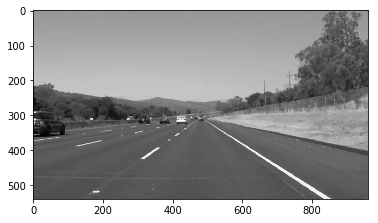

In [38]:
gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img,cmap="gray");

In [39]:
kernel_size = 5
blur_img = cv2.GaussianBlur(gray_img , (kernel_size, kernel_size), 0)

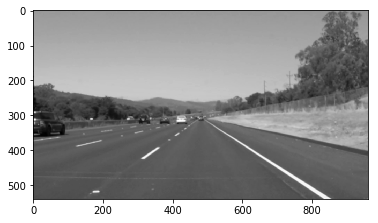

In [40]:
plt.imshow(blur_img,cmap="gray")

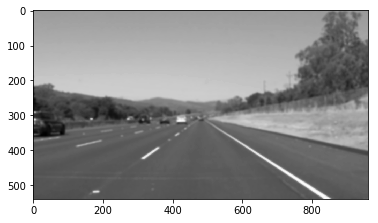

In [41]:
blur_bf = cv2.bilateralFilter(gray_img,9,130,130)
plt.imshow(blur_bf,cmap="gray")

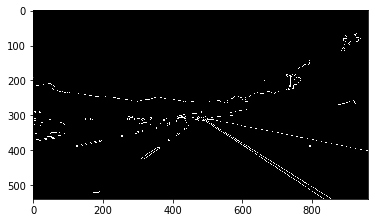

In [42]:
canny_img = cv2.Canny(blur_img, 50, 150,L2gradient=True)
plt.imshow(canny_img,cmap="gray")

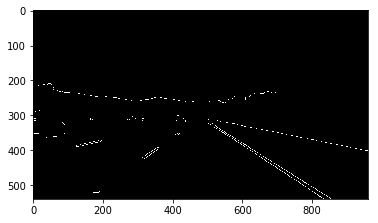

In [43]:
canny_img = cv2.Canny(blur_bf, 50,150,L2gradient=True)
plt.imshow(canny_img,cmap="gray")

In [44]:
gaussian_blur?

In [45]:
billateral_blur?

In [46]:
canny_edge?

<a id="hough"/>

### HoughLines

In [47]:
rho=2
theta=np.pi/180
threshold=20
min_line_length=40
max_line_gap=15
roi_img = region_of_interest(canny_img)
lines = cv2.HoughLinesP(roi_img, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
print(lines)

[[[524 332 853 538]]

 [[505 325 808 522]]

 [[311 423 355 392]]

 [[318 425 361 395]]

 [[545 350 719 463]]

 [[532 338 853 539]]

 [[739 478 797 515]]

 [[313 421 354 392]]

 [[319 425 360 396]]]


<a id="line"/>

### Class Line

In [48]:
Line?

In [49]:
   
l1 = Line([318, 361], [425, 395])
l2 = Line([313, 354], [421, 392])

In [50]:
l1.m , l1.b

(-0.69767441860465396, 646.86046511628001)

In [51]:
l1.is_vertical()

True

In [52]:
l1.is_left_line()

False

In [53]:
l2.is_left_line()

False

In [54]:
l_fit = l1.fit(l2)
l_fit.m , l_fit.b

(-0.67646408084615972, 636.04292587577368)

In [55]:
from IPython.core.debugger import set_trace


right_line = None
left_line = None
for line in lines:
    for x1,y1,x2,y2 in line:
        #set_trace()
        l = Line([x1,x2],[y1,y2])
        if l.is_vertical():
            if l.is_left_line():
                if not left_line:
                    left_line = l
                else:
                    left_line = left_line.fit(l)

            else:
                if not right_line:
                    right_line = l
                else:
                    right_line = right_line.fit(l)
print(left_line.m, left_line.b)
print(right_line.m, right_line.b)

0.630693973178 4.22758830383
-0.677997578927 636.640889666


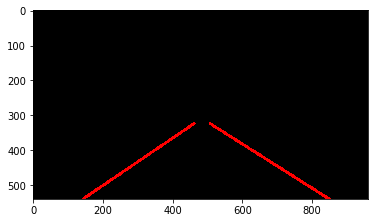

In [56]:
line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
left_line.draw(line_img)
right_line.draw(line_img)
plt.imshow(line_img)

<a id="pipe2"/>

In [57]:
def pipeline2(img):
    gray_img = grayscale(img)
    blur_img = gaussian_blur(gray_img)
    canny = canny_edge(blur_img)
    roi_img = region_of_interest(canny)
    lines = hough_lines(roi_img)
    lines = fit_lines(lines)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        if line:
            line.draw(line_img)

    
    return weighted_img(line_img,img)

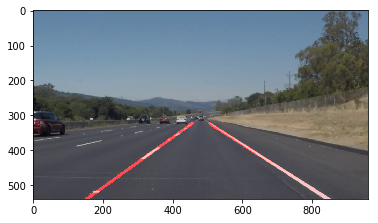

In [58]:
line_img = pipeline2(image )
plt.imshow(line_img,cmap="gray")

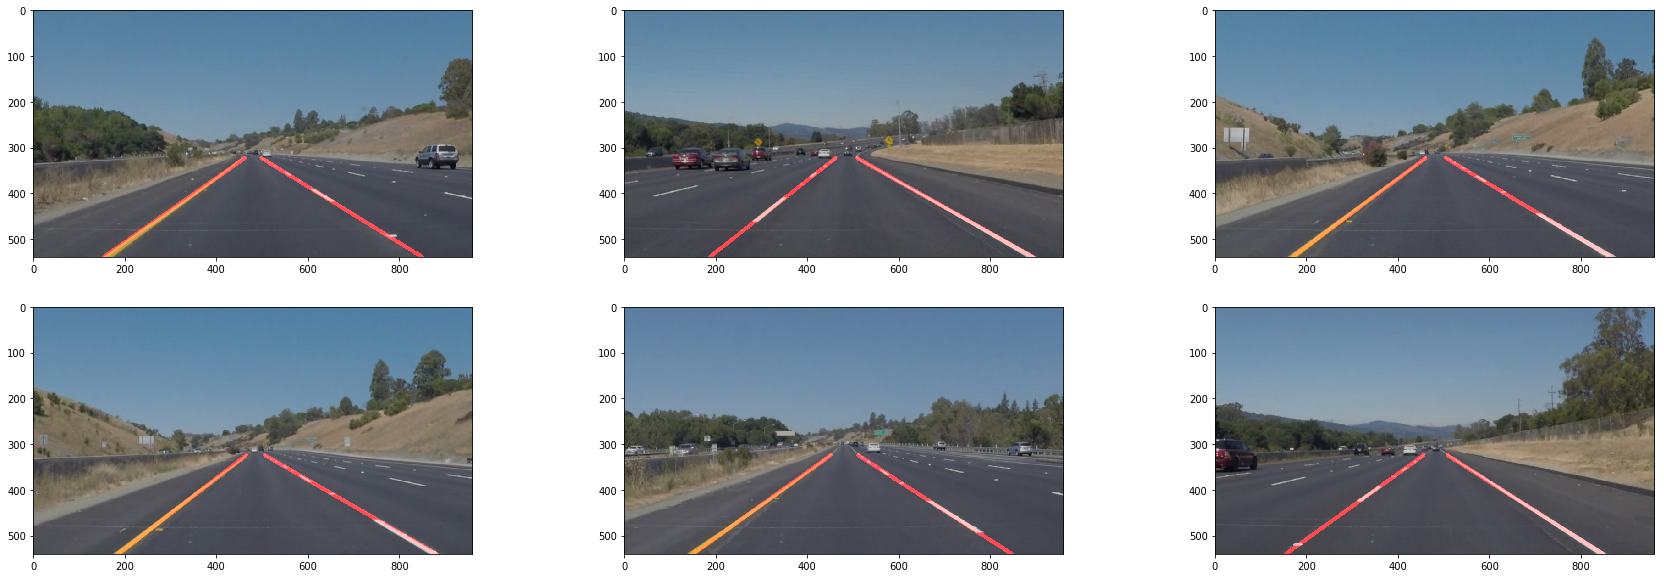

In [59]:
test_functions(p,pipeline2)

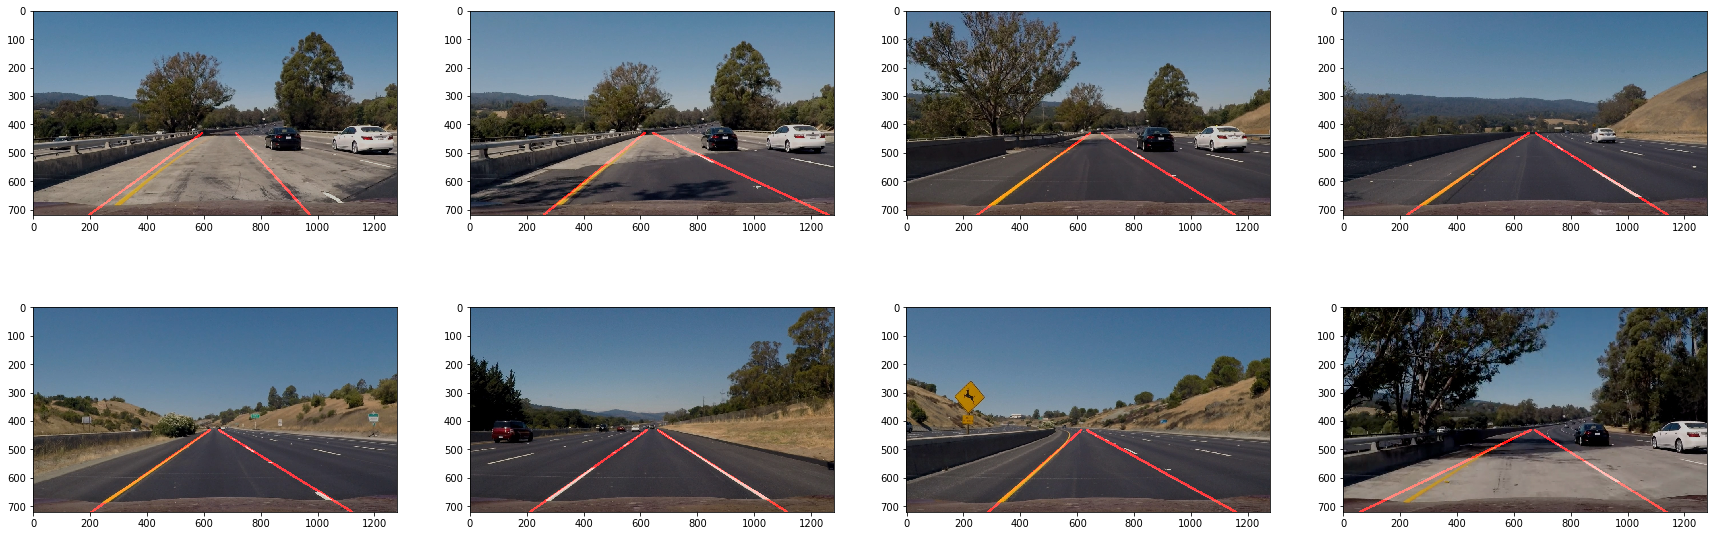

In [60]:
test_functions(p2,pipeline2)

In [61]:
clip_output2 = 'test_videos_output/solidWhiteRight-pipeline2.mp4'

test_video(clip, pipeline2,clip_output2)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight-pipeline2.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight-pipeline2.mp4


100%|█████████▉| 221/222 [00:05<00:00, 35.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight-pipeline2.mp4 



In [62]:
%%HTML
<video width="320" height="240" controls>
  <source src='test_videos_output/solidWhiteRight-pipeline2.mp4' type="video/mp4">
</video>

In [63]:
clip2_out2 = 'test_videos_output/solidYellowLeft-pipeline2.mp4'

test_video(clip2,pipeline2,clip2_out2)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft-pipeline2.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft-pipeline2.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft-pipeline2.mp4 



In [64]:
%%HTML
<video width="320" height="240" controls>
  <source src='test_videos_output/solidWYellowLeft-pipeline2.mp4' type="video/mp4">
</video>

In [65]:
challenge_out2 = 'test_videos_output/challenge_2.mp4'

test_video(clip_challenge, pipeline2,challenge_out2)

[MoviePy] >>>> Building video test_videos_output/challenge_2.mp4
[MoviePy] Writing video test_videos_output/challenge_2.mp4


100%|██████████| 251/251 [00:20<00:00, 18.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_2.mp4 



In [66]:
%%HTML
<video width="520" height="360" controls>
  <source src='test_videos_output/challenge_2.mp4' type="video/mp4">
</video>

In [67]:
def pipeline3(img):
    gray_img = grayscale(img)
    blur_img = billateral_blur(gray_img)
    canny = canny_edge(blur_img)
    roi_img = region_of_interest(canny)
    lines = hough_lines(roi_img)
    lines = fit_lines(lines)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        if line:
            line.draw(line_img)

    
    return weighted_img(line_img,img)

In [68]:
clip_output3 = 'test_videos_output/solidWhiteRight-pipeline3.mp4'

test_video(clip, pipeline3,clip_output3)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight-pipeline3.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight-pipeline3.mp4


100%|█████████▉| 221/222 [00:09<00:00, 23.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight-pipeline3.mp4 



In [69]:
%%HTML
<video width="520" height="360" controls>
  <source src='test_videos_output/solidWhiteRight-pipeline3.mp4' type="video/mp4">
</video>

In [70]:
clip2_out3 = 'test_videos_output/solidYellowLeft-pipeline3.mp4'

test_video(clip2,pipeline3,clip2_out3)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft-pipeline3.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft-pipeline3.mp4


100%|█████████▉| 681/682 [00:31<00:00, 21.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft-pipeline3.mp4 



In [71]:
%%HTML
<video width="520" height="360" controls>
  <source src='test_videos_output/solidYellowLeft-pipeline3.mp4' type="video/mp4">
</video>

In [72]:
challenge_out3 = 'test_videos_output/challenge_3.mp4'

test_video(clip_challenge, pipeline3,challenge_out3)

[MoviePy] >>>> Building video test_videos_output/challenge_3.mp4
[MoviePy] Writing video test_videos_output/challenge_3.mp4


100%|██████████| 251/251 [00:23<00:00, 10.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_3.mp4 



In [73]:
%%HTML
<video width="520" height="360" controls>
  <source src='test_videos_output/challenge_3.mp4' type="video/mp4">
</video>